In [1]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
import tensorflow as tf
%matplotlib inline

### load sample image

[[ 53.         68.0000175 405.        478.9998225   0.       ]
 [202.         20.99992   496.        486.99978     0.       ]
 [589.         77.0001275 737.        335.9999825   0.       ]
 [723.        327.000125  793.        396.000295    1.       ]]


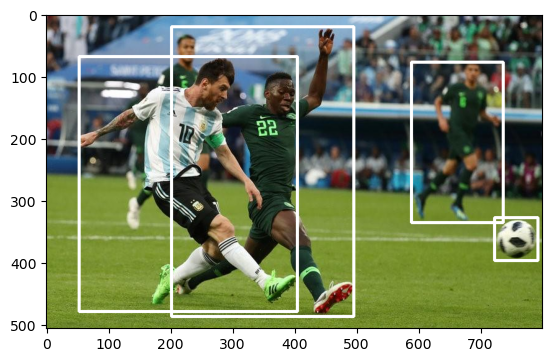

In [2]:
img = cv2.imread("messi.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = pkl.load(open("messi_ann.pkl", "rb"))

#inspect the bounding boxes
print(bboxes)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

### load TA image from `2023-datalab-cup2-object-detection/pascal_voc_training_data.txt`
- format of `2023-datalab-cup2-object-detection/pascal_voc_training_data.txt`:
```
000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6
```

In [3]:
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                "bus", "car", "cat", "chair", "cow",
                "diningtable", "dog", "horse", "motorbike", "person",
                "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
# class_collector is a dictionary that accumulates the number of bounding boxes for each class
class_lib = {}

In [4]:
train_dataset_bboxes_path = '../2023-datalab-cup2-object-detection/pascal_voc_training_data.txt'
bbox_lib = {}
augmented_time = {}

image_name_list = []
object_num_list = []
object_class_list = []

with open(train_dataset_bboxes_path) as f:
    train_dataset_bboxes = f.readlines()
    # read out all the bboxes
    cnt = 0
    for line in train_dataset_bboxes:
        line = line.strip().split()
        # print(line)
        
        # 0: image name
        # rest: bboxes
        img_name = line[0]
        tmp_ls = []
        local_object_class_list = []
        
        bbox = line[1:]
    
        image_name_list.append(img_name)
        object_num_list.append(len(bbox)//5)
        # for each bbox, we have 5 elements.
        for i in range(len(bbox)//5):
            # convert it from string to int
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
            class_type = int(bbox[i*5+4])
            local_object_class_list.append(class_type)
            class_name = classes_name[class_type]
            if class_name not in class_lib:
                class_lib[class_name] = 1
            else:
                class_lib[class_name] += 1
        # convert tmp_ls to np array
        tmp_ls = np.array(tmp_ls)
        bbox_lib[img_name] = tmp_ls
        # oject class list
        object_class_list.append(local_object_class_list)
        augmented_time[img_name] = 1
        

### analyze distribution

In [5]:
class_count = np.zeros(20, int)
for row in range(5):
    for col in range(4):
        index = row*4+col
        class_count[index] = class_lib[classes_name[index]]
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} {class_lib[class_name]:8d} {class_count[index]:5d}', end='<|')
    print()

   0) aeroplane         331   331<|   1) bicycle           417   417<|   2) bird              599   599<|   3) boat              398   398<|
   4) bottle            629   629<|   5) bus               272   272<|   6) car              1636  1636<|   7) cat               389   389<|
   8) chair            1425  1425<|   9) cow               356   356<|  10) diningtable       309   309<|  11) dog               536   536<|
  12) horse             403   403<|  13) motorbike         390   390<|  14) person           5392  5392<|  15) pottedplant       620   620<|
  16) sheep             353   353<|  17) sofa              419   419<|  18) train             328   328<|  19) tvmonitor         366   366<|


In [6]:
rep_class_lib = class_lib.copy()
lower_bound = 3000
# sort and be descending
descend_object_num_index = np.argsort(object_num_list)[::-1]
invalid_ele = np.zeros(len(object_num_list), int)

while True:
    for i in descend_object_num_index:
        local_object_class_list = object_class_list[i]
        if invalid_ele[i] or (class_count[local_object_class_list] >= lower_bound).any():
            invalid_ele[i] = 1
            continue
        else:
            augmented_time[image_name_list[i]] += 1
            for c in local_object_class_list:
                class_count[c] += 1
    if (class_count >= lower_bound).all():
        break

In [7]:
# sum up the augmented time
augmented_time_sum = 0
for k, v in augmented_time.items():
    augmented_time_sum += v
    
# sum up the original version
original_time_sum = 0
for k, v in class_lib.items():
    original_time_sum += v
print(f'augmented time sum: {augmented_time_sum}')
print(f'original time sum: {original_time_sum}')

# output the max augmented time
max_augmented_time = 0
max_augmented_time_img_name = ''
for k, v in augmented_time.items():
    if v > max_augmented_time:
        max_augmented_time = v
        max_augmented_time_img_name = k
print(f'max augmented time: {max_augmented_time}')

for row in range(5):
    for col in range(4):
        index = row*4+col
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} orig.: {class_lib[class_name]:8d} aug.: {class_count[index]:5d}', end='<|')
    print()

augmented time sum: 32814
original time sum: 15568
max augmented time: 406
   0) aeroplane    orig.:      331 aug.:  3001<|   1) bicycle      orig.:      417 aug.:  3000<|   2) bird         orig.:      599 aug.:  3000<|   3) boat         orig.:      398 aug.:  3000<|
   4) bottle       orig.:      629 aug.:  3000<|   5) bus          orig.:      272 aug.:  3000<|   6) car          orig.:     1636 aug.:  3001<|   7) cat          orig.:      389 aug.:  3000<|
   8) chair        orig.:     1425 aug.:  3003<|   9) cow          orig.:      356 aug.:  3002<|  10) diningtable  orig.:      309 aug.:  3000<|  11) dog          orig.:      536 aug.:  3000<|
  12) horse        orig.:      403 aug.:  3000<|  13) motorbike    orig.:      390 aug.:  3000<|  14) person       orig.:     5392 aug.:  5392<|  15) pottedplant  orig.:      620 aug.:  3000<|
  16) sheep        orig.:      353 aug.:  3007<|  17) sofa         orig.:      419 aug.:  3001<|  18) train        orig.:      328 aug.:  3000<|  19) tvm

### peek at a single image result

[[ 81. 279. 207. 356.   1.]]


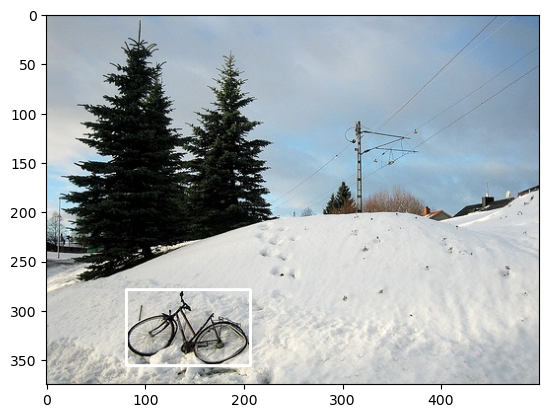

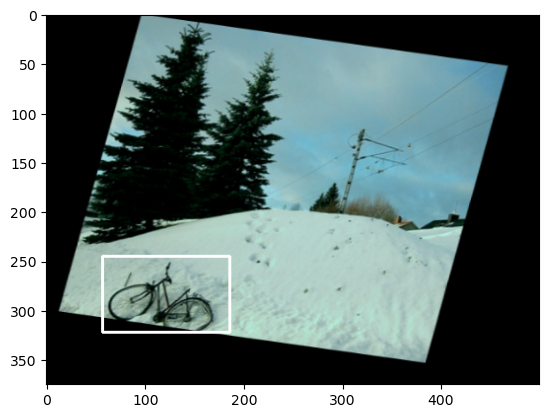

In [8]:
train_dataset_folder = '../2023-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'
image_name = '001184.jpg'

img = cv2.imread(train_dataset_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = bbox_lib[image_name]
print(bboxes)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

### create dst folder if not exist and copy bbox_lib into new_bbox_lib

In [9]:
train_dataset_folder = '../2023-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/'
dst_folder = './augmented_unbalance_images/'
# create the folder if not exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# list out all the images in the train_dataset_folder
train_dataset_images = os.listdir(train_dataset_folder)
# new_bbox_lib copy from bbox_lib. It is used to hold the augmented bboxes and the original bboxes
new_bbox_lib = bbox_lib.copy()

### apply augumentation one by one without balance
- the data is formed by np array, where each unit is a 5-element tuple
  - `[x_1,y_1,x_2,y_2, c]`, and `x_1...c` is float
- the balance can be traced by `c`. Use c's distribution to determine whether we should apply augumentation

In [10]:
# handle them one by one
for image in train_dataset_images:
    # read the image
    # img = cv2.imread(train_dataset_folder + image)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
    img = tf.io.read_file(train_dataset_folder + image)
    img = tf.image.decode_jpeg(img, channels=3)
    # get the bboxes
    if image not in bbox_lib:
        continue
    bboxes = bbox_lib[image]
    
    # TODO: USE C'S DISTRIBUTION TO DETERMINE WHETHER TO AUGMENT THE IMAGE OR NOT
    # get the total number of repeated times
    repeated_times = augmented_time[image]
    # save the original image
    img_ = tf.image.encode_jpeg(img)
    tf.io.write_file(dst_folder+image, img_)
    
    # print(f'{image} repeated times: {repeated_times}')
    repeated_times -= 1
    
    for i in range(0, repeated_times):
        # augment the image
        tmp = img.numpy().copy()
        # add random noise over the image
        noise = np.random.normal(0, 10, tmp.shape).astype(np.uint8)
        tmp = tmp + noise
        deg = i % 180
        seq = Sequence([RandomHSV(30, 40, 50),RandomHorizontalFlip(0.7), RandomScale(0.1), RandomShear(0.15), RandomRotate(deg)])
        img_, bboxes_ = seq(tmp, bboxes.copy())
        if len(bboxes_) == 0:
            continue
        new_name = 'aug_'+ str(i) + '_' + image
        # make sure img_ is greater or equal to 0
        img_[img_ < 0] = 0
        # make sure bboxes_ is greater or equal to 0
        bboxes_[bboxes_ < 0] = 0
        # make img_ is less or equal to 255
        img_[img_ > 255] = 255
        img_ = tf.image.encode_jpeg(img_)
        tf.io.write_file(dst_folder+new_name, img_)
        # save the bboxes into the new_bbox_lib
        new_bbox_lib[new_name] = bboxes_

# convert all bboxes in new_bbox_lib to int
for key, value in new_bbox_lib.items():
    # convert value as int type
    value = value.astype(int)
    new_bbox_lib[key] = value

In [11]:
# print(new_bbox_lib['009926.jpg'])
# write the new_bbox_lib into a txt file
new_bbox_lib_path = './augmented_unbalance_images.txt'
with open(new_bbox_lib_path, 'w') as f:
    for key, value in new_bbox_lib.items():
        f.write(key)
        f.write(' ')
        for bbox in value:
            for element in bbox:
                f.write(str(element))
                f.write(' ')
        f.write('\n')

### verify the augmeunted_unbalance_images.txt and the image

In [12]:
# first read the augmented_unbalance_images.txt
augmented_unbalance_images_path = './augmented_unbalance_images.txt'
test_bbox_lib = {}

with open(augmented_unbalance_images_path) as f:
    buffer = f.readlines()
    for line in buffer:
        line = line.strip().split()
        image_name = line[0]
        tmp_ls = []
        bbox = line[1:]
        for i in range(len(bbox)//5):
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
        tmp_ls = np.array(tmp_ls)
        test_bbox_lib[image_name] = tmp_ls

### compare `001898.jpg`
- the original version contains 3 but the converted version only holds two
- I think it is normal, for the converted version experiences cropping

002893.jpg
[  1.   6. 494. 375.  13.] motorbike


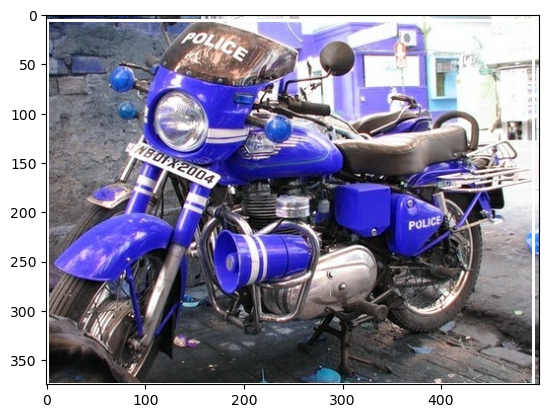

In [21]:
augumented_unbalance_images_folder = './augmented_unbalance_images/'
image_name = '002893.jpg'

img = cv2.imread(augumented_unbalance_images_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = test_bbox_lib[image_name]
print(image_name)
for bbox in bboxes:
    print(bbox, classes_name[int(bbox[4])])
# convert img from bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

aug_15_002893.jpg
[  5.   6. 499. 375.  13.] motorbike


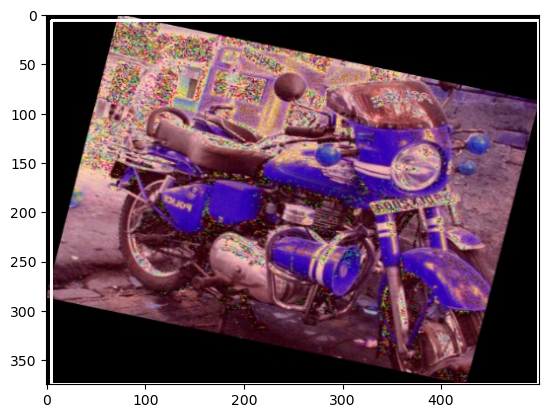

In [26]:
augumented_unbalance_images_folder = './augmented_unbalance_images/'
image_name = 'aug_15_002893.jpg'

img = cv2.imread(augumented_unbalance_images_folder + image_name)[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = test_bbox_lib[image_name]
print(image_name)
# convert img from bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for bbox in bboxes:
    print(bbox, classes_name[int(bbox[4])])
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

In [17]:
train_dataset_bboxes_path = 'augmented_unbalance_images.txt'
bbox_lib = {}
augmented_time = {}

image_name_list = []
object_num_list = []
object_class_list = []

with open(train_dataset_bboxes_path) as f:
    train_dataset_bboxes = f.readlines()
    # read out all the bboxes
    cnt = 0
    for line in train_dataset_bboxes:
        line = line.strip().split()
        # print(line)
        
        # 0: image name
        # rest: bboxes
        img_name = line[0]
        tmp_ls = []
        local_object_class_list = []
        
        bbox = line[1:]
    
        image_name_list.append(img_name)
        object_num_list.append(len(bbox)//5)
        # for each bbox, we have 5 elements.
        for i in range(len(bbox)//5):
            # convert it from string to int
            bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
            tmp_ls.append(bbox[i*5:i*5+5])
            class_type = int(bbox[i*5+4])
            local_object_class_list.append(class_type)
            class_name = classes_name[class_type]
            if class_name not in class_lib:
                class_lib[class_name] = 1
            else:
                class_lib[class_name] += 1
        # convert tmp_ls to np array
        tmp_ls = np.array(tmp_ls)
        bbox_lib[img_name] = tmp_ls
        # oject class list
        object_class_list.append(local_object_class_list)
        augmented_time[img_name] = 1


In [18]:
class_count = np.zeros(20, int)
for row in range(5):
    for col in range(4):
        index = row*4+col
        class_count[index] = class_lib[classes_name[index]]
        class_name = classes_name[index]
        print(f'{index: 4d}) {class_name:12s} {class_lib[class_name]:8d} {class_count[index]:5d}', end='<|')
    print()

   0) aeroplane        3661  3661<|   1) bicycle          3834  3834<|   2) bird             4196  4196<|   3) boat             3783  3783<|
   4) bottle           4250  4250<|   5) bus              3535  3535<|   6) car              6265  6265<|   7) cat              3778  3778<|
   8) chair            5847  5847<|   9) cow              3713  3713<|  10) diningtable      3618  3618<|  11) dog              4072  4072<|
  12) horse            3806  3806<|  13) motorbike        3780  3780<|  14) person          16176 16176<|  15) pottedplant      4235  4235<|
  16) sheep            3698  3698<|  17) sofa             3838  3838<|  18) train            3647  3647<|  19) tvmonitor        3729  3729<|
